Importing libraries

In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio
import torch
from sklearn.model_selection import train_test_split

Visualising single audio

In [ ]:
random_file = "test_data/kansas-blues-blues-rock-instrumental-259874.mp3"
y,sr = librosa.load(random_file,sr=44100)
plt.figure(figsize=(14,5))
librosa.display.waveshow(y,sr=sr)
plt.title("Metal")
plt.show()

Playing audio

In [3]:
from IPython.display import Audio
Audio(data=y,rate=sr)

Doing visualisation on chunks of audio

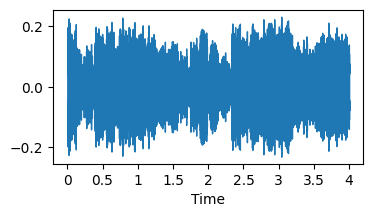

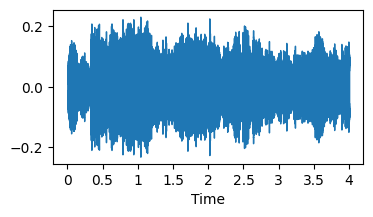

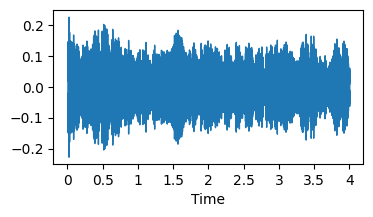

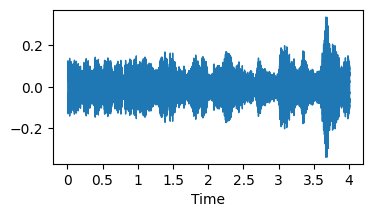

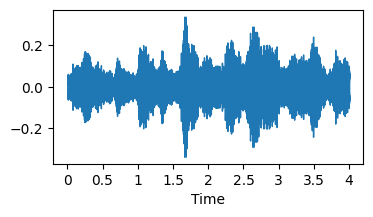

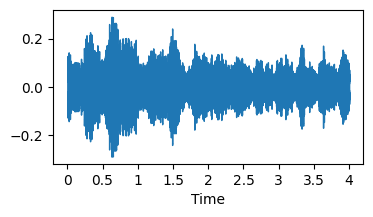

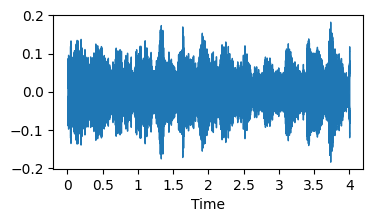

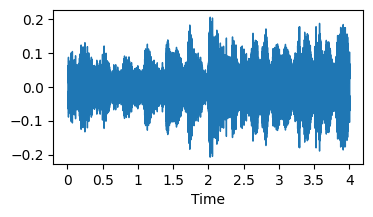

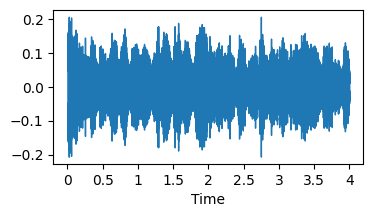

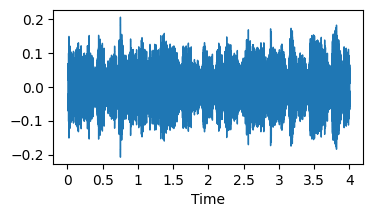

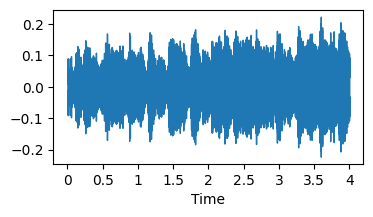

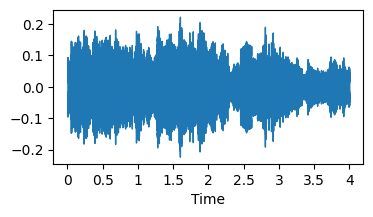

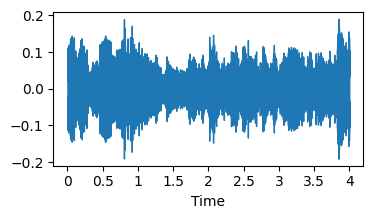

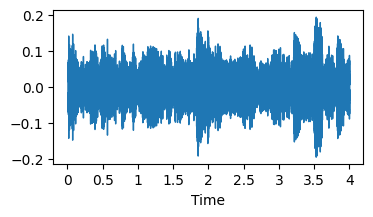

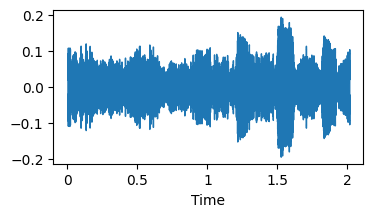

In [2]:
random_file = "/mnt/d/DLprojects/Music_genre_classifier/dataset/Data/genres_original/classical/classical00002.wav"
y,sr = librosa.load(random_file,sr=None) #sr=None to keep original sampling rate

# define duration of each chunk and overlap
chunk_duration=4
overlap_duration=2

# convert duration to sample
chunk_sample = chunk_duration * sr
overlap_sample = overlap_duration * sr

# no of chunks
num_chunks = int(np.ceil((len(y)-chunk_sample)/(chunk_sample-overlap_sample)))+1

# iterate over chunks
for i in range(num_chunks):
    # calculate start and end indices of the chunk
    start = i*(chunk_sample-overlap_sample)
    end = start+chunk_sample
    chunk = y[start:end]
    plt.figure(figsize=(4,2))
    librosa.display.waveshow(chunk,sr=sr)
    plt.show()


Melspectogram visualisation

In [3]:
def plot_melspectogram(y,sr):
    # compute spectogram
    spectogram = librosa.feature.melspectrogram(y=y,sr=sr)
    # changing scale to dB
    spectogram_dB = librosa.power_to_db(spectogram,ref=np.max)
    # melspect visualization
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spectogram_dB,sr=sr,x_axis='time',y_axis='mel')
    plt.colorbar(format="%2.0f dB")
    plt.title("Melspectogram")
    plt.tight_layout()
    plt.show()

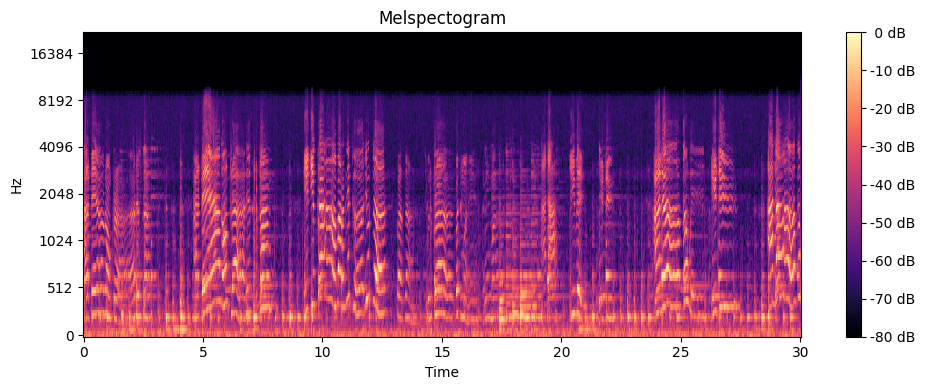

In [4]:
random_file = "/mnt/d/DLprojects/Music_genre_classifier/dataset/Data/genres_original/blues/blues00016.wav"
y1,sr1 = librosa.load(random_file,sr=44100)
plot_melspectogram(y1,sr1)

In [5]:
def plot_melspectogram_chunks(y,sr):
    # define duration of each chunk and overlap
    chunk_duration=4
    overlap_duration=2

    # convert duration to sample
    chunk_sample = chunk_duration * sr
    overlap_sample = overlap_duration * sr

    # no of chunks
    num_chunks = int(np.ceil((len(y)-chunk_sample)/(chunk_sample-overlap_sample)))+1

    # iterate over chunks
    for i in range(num_chunks):
        # calculate start and end indices of the chunk
        start = i*(chunk_sample-overlap_sample)
        end = start+chunk_sample
        chunk = y[start:end]
        # melspectogram part
        spectogram = librosa.feature.melspectrogram(y=chunk,sr=sr)
        spectogram_dB = librosa.power_to_db(spectogram,ref=np.max)
        # visualize melspectogram
        plt.figure(figsize=(10,4))
        librosa.display.specshow(spectogram_dB,sr=sr,x_axis='time',y_axis='mel')
        plt.colorbar(format="%2.0f dB")
        plt.title("Melspectogram")
        plt.tight_layout()
        plt.show()

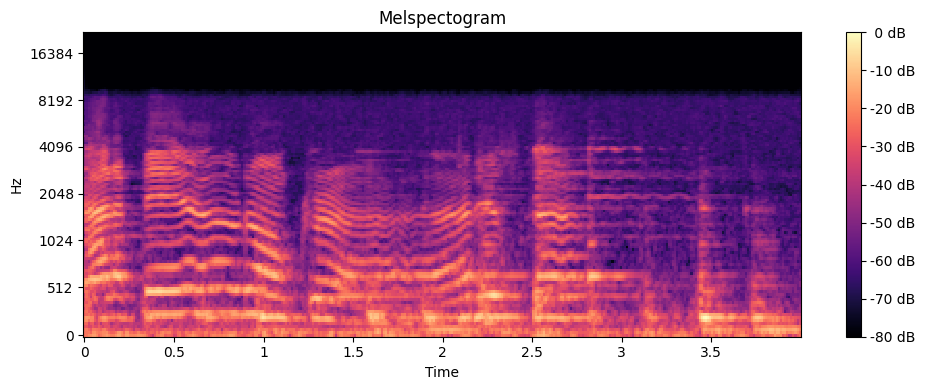

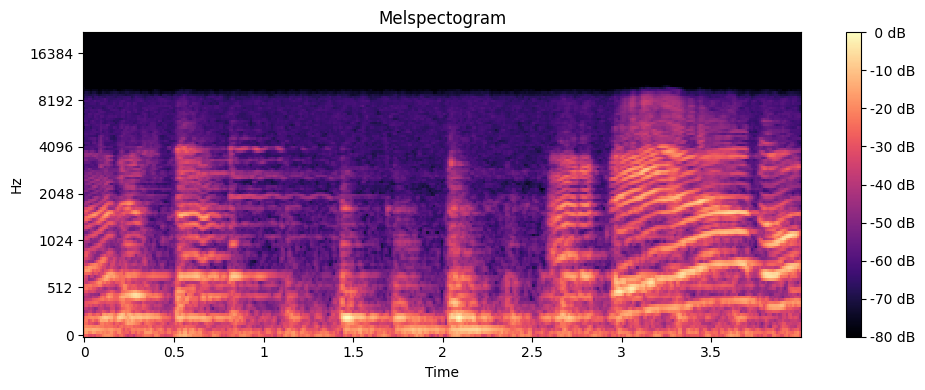

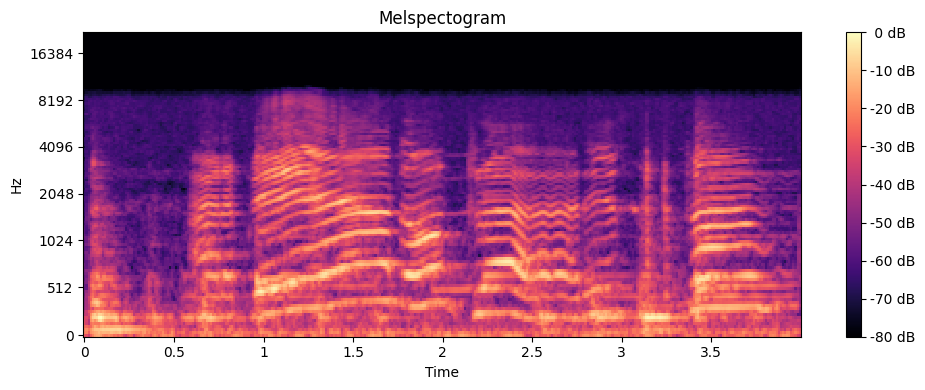

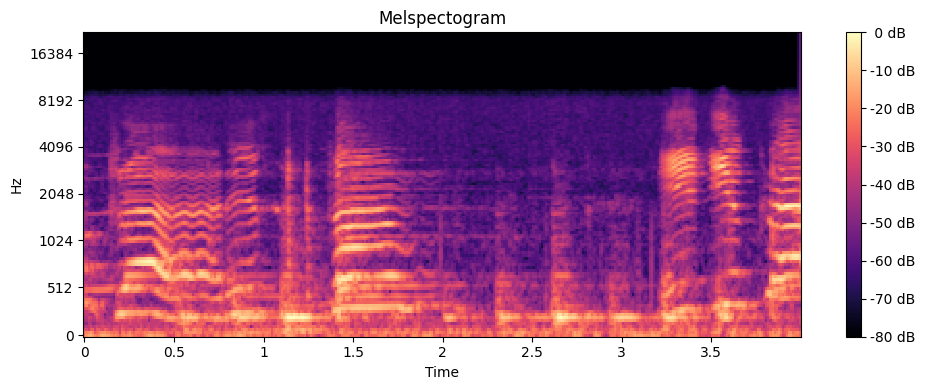

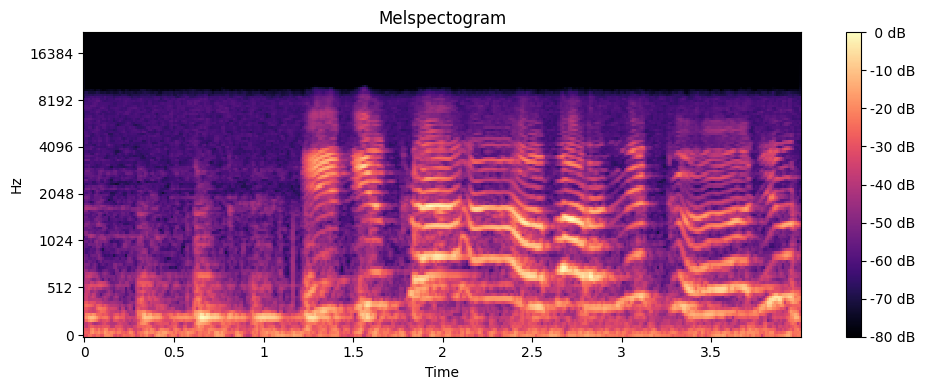

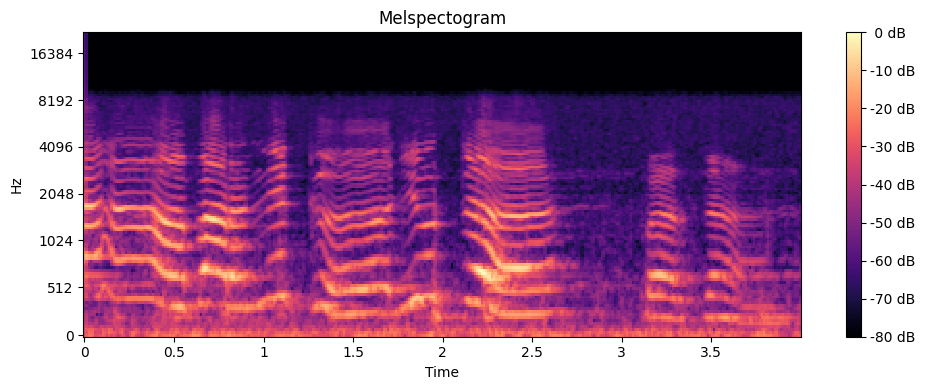

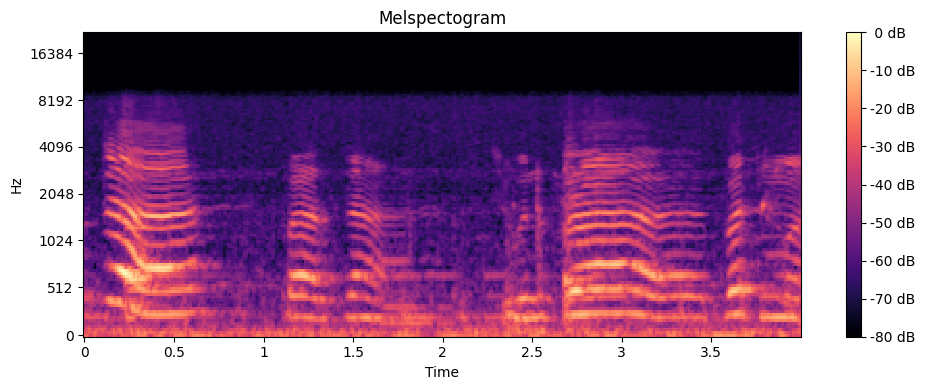

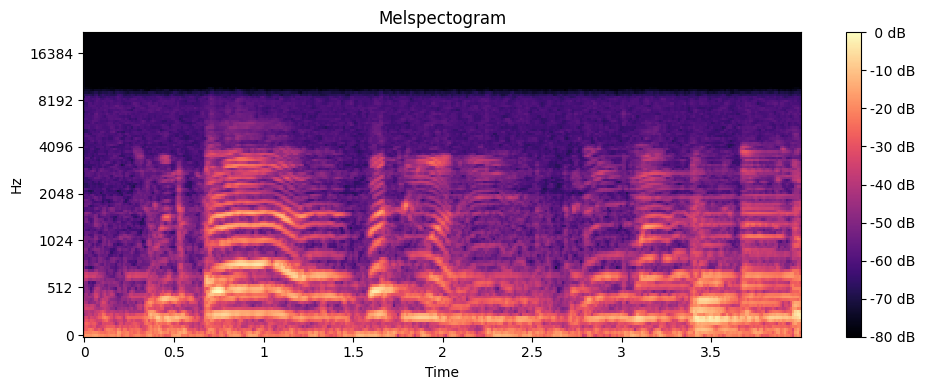

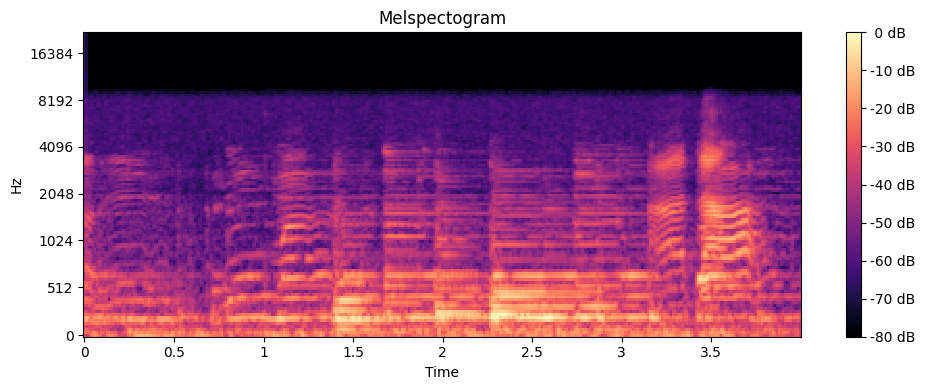

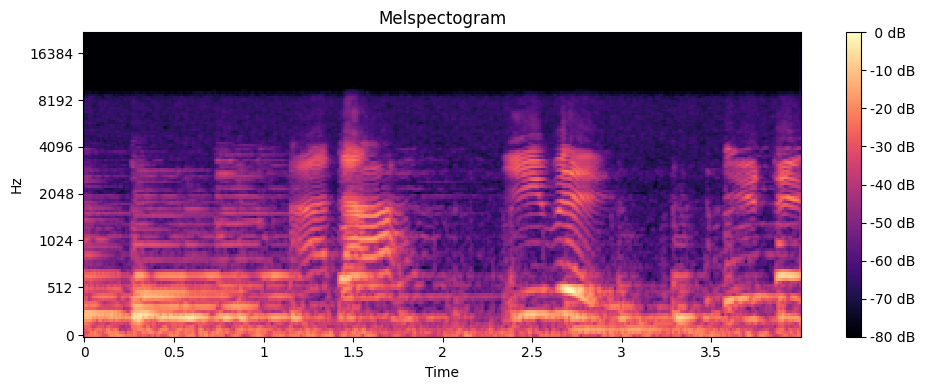

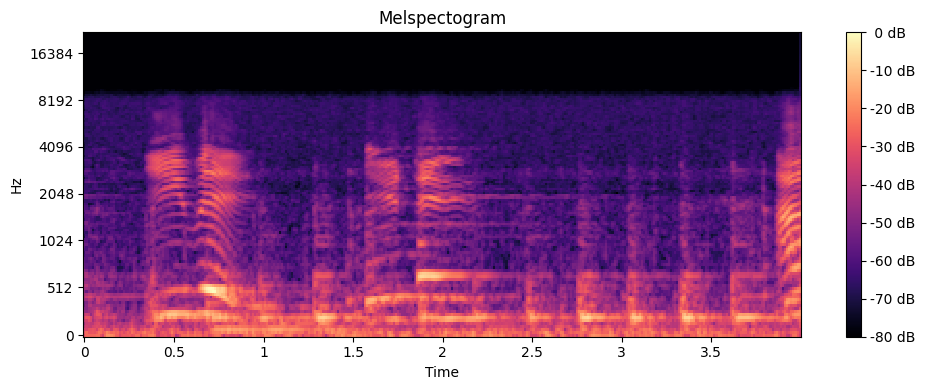

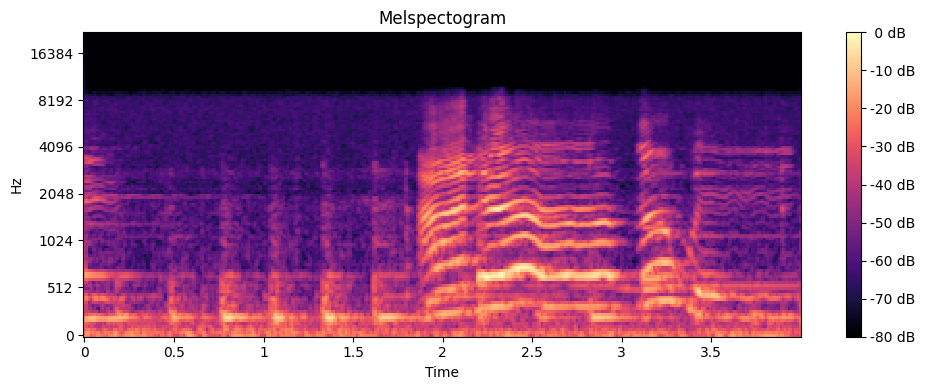

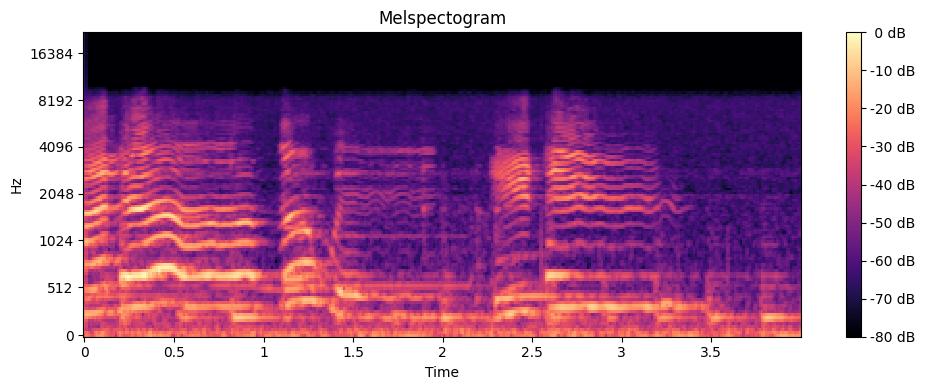

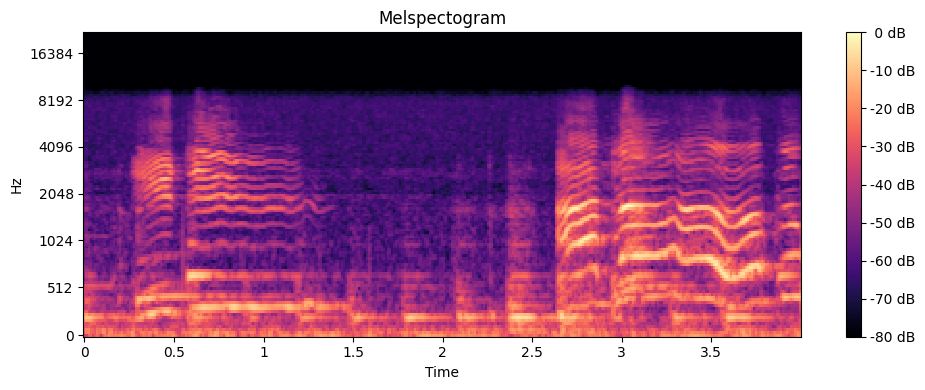

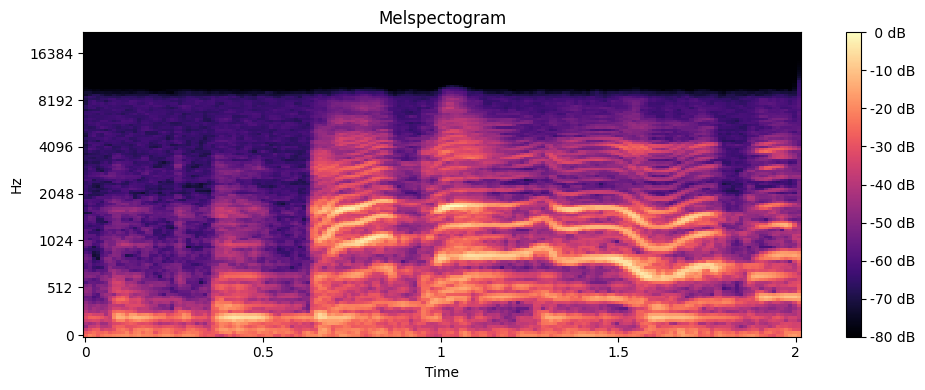

In [6]:
plot_melspectogram_chunks(y1,sr1)

Data preprocessing

In [7]:
def remove_underscore_from_filenames(data_dir, classes):
    # Loop over all specified genre directories
    for genre in classes:
        genre_path = os.path.join(data_dir, genre)
        # Check if it is a directory
        if os.path.isdir(genre_path):
            print(f"Processing directory: {genre}")  # Debugging step
            # Loop over each file in the genre directory
            for filename in os.listdir(genre_path):
                # Only process .wav files
                if filename.endswith('.wav'):
                    print(f"Found file: {filename}")  # Debugging step
                    # Check if the filename contains an underscore (e.g., "blues_0000.wav")
                    if '_' in filename:
                        # Remove the underscore and create a new filename (e.g., "blues0000.wav")
                        new_filename = filename.replace('_', '')
                        # Define full file paths
                        old_file_path = os.path.join(genre_path, filename)
                        new_file_path = os.path.join(genre_path, new_filename)
                        
                        # Rename the file
                        os.rename(old_file_path, new_file_path)
                        print(f"Renamed: {filename} -> {new_filename}")  # Confirm renaming
                    else:
                        print(f"No renaming needed for: {filename}")  # Debugging if no underscore is found
        else:
            print(f"Skipping non-directory: {genre_path}")  # Skip if it's not a directory

In [8]:
data_dir = "/mnt/d/DLprojects/Music_genre_classifier/dataset/Data/genres_original"
classes = ['blues','classical','country','disco','hiphop','jazz','metal',
           'pop','reggae','rock']

In [9]:
#remove_underscore_from_filenames(data_dir, classes)

In [10]:
def load_and_preprocess_data(data_dir, classes, target_shape=(210, 210)):
    data = []
    labels = []

    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing--", class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                
                # Load the audio using torchaudio
                waveform, sample_rate = torchaudio.load(file_path)
                
                # Convert the waveform to a numpy array for compatibility with the rest of the pipeline
                audio_data = waveform.numpy().flatten()
                
                # Perform preprocessing
                chunk_duration = 4
                overlap_duration = 2
                
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate
                
                num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
                
                for i in range(num_chunks):
                    start = i * (chunk_samples - overlap_samples)
                    end = start + chunk_samples
                    chunk = audio_data[start:end]
                    
                    # Convert chunk to Mel Spectrogram
                    mel_spectrogram = torchaudio.transforms.MelSpectrogram()(torch.tensor(chunk).unsqueeze(0)).numpy()
                    
                    # Resize matrix based on provided target shape
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                    
                    data.append(mel_spectrogram)
                    labels.append(i_class)

    return np.array(data), np.array(labels)


In [11]:
data,labels = load_and_preprocess_data(data_dir,classes)

Processing-- blues


/mnt/d/DLprojects/myenv/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
I0000 00:00:1731153121.642231   17546 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock


In [12]:
data.shape

(14975, 1, 210, 210, 1)

In [13]:
data=np.squeeze(data,axis=1)

In [14]:
data.shape

(14975, 210, 210, 1)

In [15]:
labels.shape

(14975,)

In [16]:
# converting labels to one hot encoding
labels=to_categorical(labels,num_classes=len(classes))
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [17]:
labels.shape

(14975, 10)

Splitting the data in training and testing

In [18]:
x_train,x_test,y_train,y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

In [19]:
x_train.shape

(11980, 210, 210, 1)

In [20]:
x_test.shape

(2995, 210, 210, 1)

In [21]:
y_train.shape

(11980, 10)

In [22]:
y_test.shape

(2995, 10)

Model building

In [23]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.models.Sequential()

# First block
model.add(Conv2D(filters=32, kernel_size=3, padding='same', input_shape=x_train[0].shape,
                 kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU instead of ReLU
model.add(Conv2D(filters=32, kernel_size=3, kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU instead of ReLU
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.3))

# Second block
model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU instead of ReLU
model.add(Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU instead of ReLU
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.3))

# Third block
model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU instead of ReLU
model.add(Conv2D(filters=128, kernel_size=3, kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU instead of ReLU
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.4))

# Fourth block
model.add(Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU instead of ReLU
model.add(Conv2D(filters=256, kernel_size=3, kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU instead of ReLU
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.4))

# Fifth block
model.add(Conv2D(filters=512, kernel_size=3, padding='same', kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU instead of ReLU
model.add(Conv2D(filters=512, kernel_size=3, kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU instead of ReLU
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.5))

# Flattening and fully connected layers
model.add(Flatten())
model.add(Dense(units=600, kernel_regularizer=l2(0.01)))  # Reduced number of units
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU instead of ReLU
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=len(classes), activation='softmax'))

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


/mnt/d/DLprojects/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/mnt/d/DLprojects/myenv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [24]:
"""from tensorflow.keras.models import load_model

# Load the model
model = load_model('Trained_model.h5')"""

"from tensorflow.keras.models import load_model\n\n# Load the model\nmodel = load_model('Trained_model.h5')"

In [25]:
# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
class ClearMemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session()

In [27]:
training_history = model.fit(x_train,y_train,epochs=100,batch_size=16,validation_data=(x_test,y_test),callbacks=[ClearMemoryCallback(),early_stopping])

Epoch 1/100


I0000 00:00:1731153649.448969   17904 service.cc:148] XLA service 0x7f7084006870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731153649.454316   17904 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-11-09 12:00:50.673426: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731153651.900356   17904 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1731153666.932615   17904 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


749/749 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - accuracy: 0.1721 - loss: 24.0739 - val_accuracy: 0.2641 - val_loss: 12.0475
Epoch 2/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.3959 - loss: 9.7648 - val_accuracy: 0.3806 - val_loss: 5.8511
Epoch 3/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.4624 - loss: 4.7949 - val_accuracy: 0.4908 - val_loss: 3.2876
Epoch 4/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.5125 - loss: 3.0160 - val_accuracy: 0.5669 - val_loss: 2.3636
Epoch 5/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.5501 - loss: 2.3120 - val_accuracy: 0.5456 - val_loss: 2.1344
Epoch 6/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.5828 - loss: 2.0034 - val_accuracy: 0.5950 - val_loss: 1.8680
Epoch 7/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - accuracy: 0.5861 - loss: 1.8588 - val_accuracy: 0.6117 - val_loss: 1.7199
Epoch 8/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.6010 - loss: 1.7501 - va

In [28]:
model.save("Trained_model1.h5")

Model Evaluation

In [ ]:
train_loss,train_acc = model.evaluate(x_train,y_train)